In [ ]:

from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.window import Window
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.regression import *
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
import time

In [ ]:

spark = SparkSession.builder.appName("NYC Taxi Project Phase 3").getOrCreate()



In [ ]:
path='yellow_tripdata_2016-02.csv'
df = spark.read.option("header", True).option("inferSchema", True).csv(path).limit(100000)

In [27]:
df.printSchema()
df.show(5)

root
 |-- VendorID: integer (nullable = true)
 |-- tpep_pickup_datetime: timestamp (nullable = true)
 |-- tpep_dropoff_datetime: timestamp (nullable = true)
 |-- passenger_count: integer (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- pickup_longitude: double (nullable = true)
 |-- pickup_latitude: double (nullable = true)
 |-- RatecodeID: integer (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- dropoff_longitude: double (nullable = true)
 |-- dropoff_latitude: double (nullable = true)
 |-- payment_type: integer (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- extra: double (nullable = true)
 |-- mta_tax: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- tolls_amount: double (nullable = true)
 |-- improvement_surcharge: double (nullable = true)
 |-- total_amount: double (nullable = true)

+--------+--------------------+---------------------+---------------+-------------+------------------+---------------

In [ ]:

df = df.dropna()
df = df.drop("store_and_fwd_flag")

df = df.dropna(subset=["tpep_pickup_datetime", "tpep_dropoff_datetime", "passenger_count", "trip_distance", "fare_amount"])

df = df.withColumn("pickup_datetime", to_timestamp("tpep_pickup_datetime"))
df = df.withColumn("dropoff_datetime", to_timestamp("tpep_dropoff_datetime"))

df = df.withColumn("duration", (unix_timestamp("dropoff_datetime") - unix_timestamp("pickup_datetime")) / 60.0)
df = df.filter((col("duration") >= 1) & (col("duration") <= 180))

df = df.filter((col("fare_amount") > 0) & (col("trip_distance") > 0) & (col("passenger_count") > 0))

df = df.dropDuplicates()

df = df.withColumn("pickup_hour", hour("pickup_datetime"))\
         .withColumn("pickup_day", dayofmonth("pickup_datetime"))\
         .withColumn("pickup_month", month("pickup_datetime"))

windowSpec = Window.partitionBy("pickup_hour").orderBy("pickup_datetime").rowsBetween(-5, 0)
df = df.withColumn("rolling_avg_fare", avg("fare_amount").over(windowSpec))

In [29]:
df.describe().show()

+-------+-------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+-------------------+--------------------+-----------------+-------------------+---------------------+------------------+------------------+------------------+------------------+------------+------------------+
|summary|           VendorID|   passenger_count|     trip_distance|  pickup_longitude|   pickup_latitude|        RatecodeID| dropoff_longitude|  dropoff_latitude|      payment_type|       fare_amount|              extra|             mta_tax|       tip_amount|       tolls_amount|improvement_surcharge|      total_amount|          duration|       pickup_hour|        pickup_day|pickup_month|  rolling_avg_fare|
+-------+-------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------

In [30]:
df.printSchema()
df.show(5)

root
 |-- VendorID: integer (nullable = true)
 |-- tpep_pickup_datetime: timestamp (nullable = true)
 |-- tpep_dropoff_datetime: timestamp (nullable = true)
 |-- passenger_count: integer (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- pickup_longitude: double (nullable = true)
 |-- pickup_latitude: double (nullable = true)
 |-- RatecodeID: integer (nullable = true)
 |-- dropoff_longitude: double (nullable = true)
 |-- dropoff_latitude: double (nullable = true)
 |-- payment_type: integer (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- extra: double (nullable = true)
 |-- mta_tax: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- tolls_amount: double (nullable = true)
 |-- improvement_surcharge: double (nullable = true)
 |-- total_amount: double (nullable = true)
 |-- pickup_datetime: timestamp (nullable = true)
 |-- dropoff_datetime: timestamp (nullable = true)
 |-- duration: double (nullable = true)
 |-- pickup_hour: integer (

In [31]:
print("Summary Stats:")
df.describe().show()

Summary Stats:
+-------+-------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+-------------------+--------------------+-----------------+-------------------+---------------------+------------------+------------------+------------------+------------------+------------+------------------+
|summary|           VendorID|   passenger_count|     trip_distance|  pickup_longitude|   pickup_latitude|        RatecodeID| dropoff_longitude|  dropoff_latitude|      payment_type|       fare_amount|              extra|             mta_tax|       tip_amount|       tolls_amount|improvement_surcharge|      total_amount|          duration|       pickup_hour|        pickup_day|pickup_month|  rolling_avg_fare|
+-------+-------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+---

In [33]:
print("Average Tip by Passenger Count:")
df.groupBy("passenger_count").agg(mean("tip_amount")).show()

Average Tip by Passenger Count:
+---------------+------------------+
|passenger_count|   avg(tip_amount)|
+---------------+------------------+
|              2|1.8283556590953258|
|              6| 1.891666666666669|
|              1|1.8562654663243083|
|              3| 1.756670496323531|
|              5|1.9027214141042135|
|              4|1.6485312060065707|
+---------------+------------------+



In [34]:
print("Correlation between fare and tip:")
df.select(corr("fare_amount", "tip_amount")).show()

Correlation between fare and tip:
+-----------------------------+
|corr(fare_amount, tip_amount)|
+-----------------------------+
|           0.5070487950575272|
+-----------------------------+



In [36]:
print("Average Tip by Hour:")
df.groupBy("pickup_hour").agg(mean("tip_amount")).show()

Average Tip by Hour:
+-----------+------------------+
|pickup_hour|   avg(tip_amount)|
+-----------+------------------+
|         17|               0.0|
|         23| 1.908087181109014|
|          0|1.9976047904191618|
|         20|1.8381686046511643|
|         16|1.7701309328968922|
|         21| 1.826236977532326|
|         22|1.8666273682468955|
|          8| 1.805131196902893|
|          9| 1.816787571502858|
|         13|1.5832183908045978|
+-----------+------------------+



In [37]:
print("Trips by Hour:")
df.groupBy("pickup_hour").count().orderBy("pickup_hour").show()

Trips by Hour:
+-----------+-----+
|pickup_hour|count|
+-----------+-----+
|          0|  167|
|          8|18598|
|          9| 7692|
|         13|  174|
|         16| 1222|
|         17|    1|
|         20| 4128|
|         21|23901|
|         22|24174|
|         23|18972|
+-----------+-----+



In [ ]:

features = ["trip_distance", "pickup_hour", "pickup_day", "pickup_month", "duration", "passenger_count"]
vec_assembler = VectorAssembler(inputCols=features, outputCol="features_vec")
df = vec_assembler.transform(df)
scaler = StandardScaler(inputCol="features_vec", outputCol="features")
scaler_model = scaler.fit(df)
df = scaler_model.transform(df)



In [42]:
from pyspark.sql.functions import col as spark_col
final_data = df.select("features", spark_col("tip_amount").alias("label"))
train_data, test_data = final_data.randomSplit([0.8, 0.2], seed=42)



In [ ]:


models = [
    ("Linear Regression", LinearRegression(featuresCol="features", labelCol="label")),
    ("Decision Tree", DecisionTreeRegressor(featuresCol="features", labelCol="label")),
    ("Random Forest", RandomForestRegressor(featuresCol="features", labelCol="label")),
    ("GBT-XGBoost", GBTRegressor(featuresCol="features", labelCol="label", maxIter=100, stepSize=0.1)),
    ("GBT-AdaBoost", GBTRegressor(featuresCol="features", labelCol="label", maxIter=50, stepSize=0.2)),
    ("GBT-GradientBoosting", GBTRegressor(featuresCol="features", labelCol="label", maxIter=200, stepSize=0.05)),
    ("Linear MLP Substitute", LinearRegression(featuresCol="features", labelCol="label", regParam=0.01))
]

In [53]:
results = []

for name, estimator in models:
    print(f"\nTraining {name}...")
    try:
        start = time.time()
        model = estimator.fit(train_data)
        end = time.time()

        predictions = model.transform(test_data)
        duration = round(end - start, 2)

        # Use PySpark RegressionEvaluator for multiple metrics
        evaluator_mse = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="mse")
        evaluator_mae = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="mae")
        evaluator_r2 = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="r2")

        metrics = {
            "MSE": evaluator_mse.evaluate(predictions),
            "MAE": evaluator_mae.evaluate(predictions),
            "R2": evaluator_r2.evaluate(predictions),
            "Time": duration
        }
        results.append((name, metrics))

        print(f"{name} completed | MSE: {metrics['MSE']:.4f} | R2: {metrics['R2']:.4f} | MAE: {metrics['MAE']:.4f} | Time: {duration}s")

    except Exception as e:
        print(f"⚠️ Error training {name}: {e}")


Training Linear Regression...
Linear Regression completed | MSE: 2.9790 | R2: 0.3833 | MAE: 1.2226 | Time: 75.42s

Training Decision Tree...
Decision Tree completed | MSE: 3.1198 | R2: 0.3542 | MAE: 1.2284 | Time: 29.14s

Training Random Forest...
Random Forest completed | MSE: 3.0764 | R2: 0.3632 | MAE: 1.2252 | Time: 29.53s

Training GBT-XGBoost...
GBT-XGBoost completed | MSE: 3.2676 | R2: 0.3236 | MAE: 1.2280 | Time: 236.32s

Training GBT-AdaBoost...
GBT-AdaBoost completed | MSE: 3.3878 | R2: 0.2987 | MAE: 1.2320 | Time: 102.6s

Training GBT-GradientBoosting...
GBT-GradientBoosting completed | MSE: 3.2290 | R2: 0.3316 | MAE: 1.2281 | Time: 303.39s

Training Linear MLP Substitute...
Linear MLP Substitute completed | MSE: 2.9798 | R2: 0.3832 | MAE: 1.2227 | Time: 43.9s


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

results_df = pd.DataFrame([{
    "Model": name,
    "MSE": metrics["MSE"],
    "R2": metrics["R2"],
    "MAE": metrics["MAE"],
    "Time (s)": metrics["Time"]
} for name, metrics in results])

plt.style.use("seaborn-v0_8-colorblind")










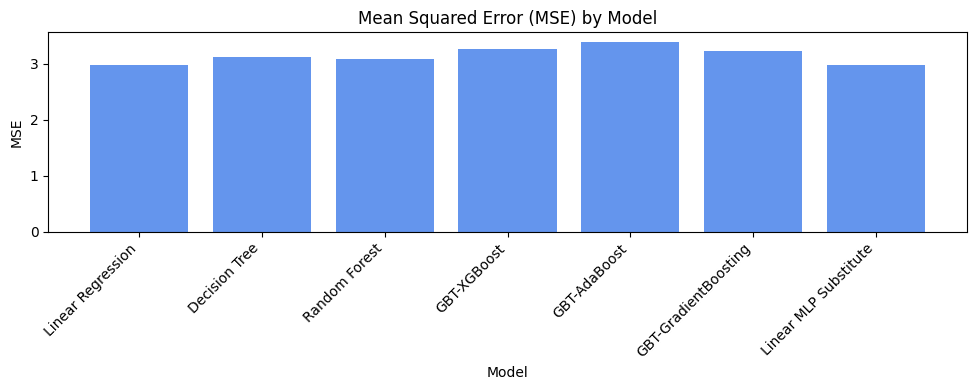

In [56]:
# Plot: MSE
plt.figure(figsize=(10, 4))
plt.bar(results_df["Model"], results_df["MSE"], color="cornflowerblue")
plt.title("Mean Squared Error (MSE) by Model")
plt.xlabel("Model")
plt.ylabel("MSE")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

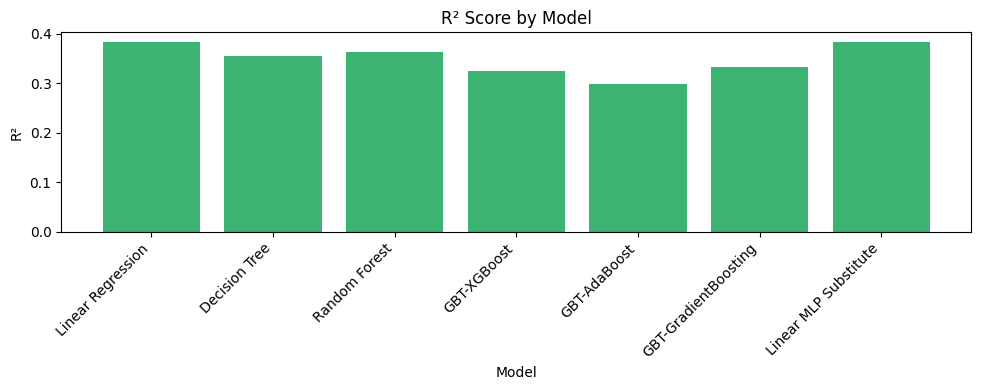

In [57]:
# Plot: R²
plt.figure(figsize=(10, 4))
plt.bar(results_df["Model"], results_df["R2"], color="mediumseagreen")
plt.title("R² Score by Model")
plt.xlabel("Model")
plt.ylabel("R²")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

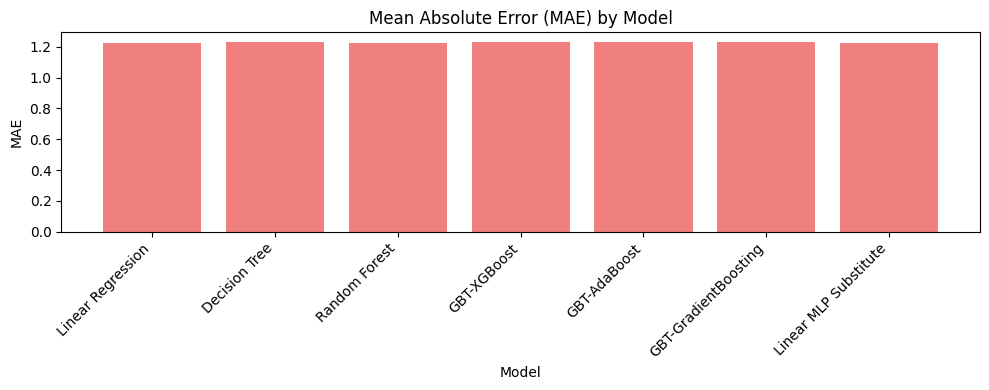

In [58]:
# Plot: MAE
plt.figure(figsize=(10, 4))
plt.bar(results_df["Model"], results_df["MAE"], color="lightcoral")
plt.title("Mean Absolute Error (MAE) by Model")
plt.xlabel("Model")
plt.ylabel("MAE")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

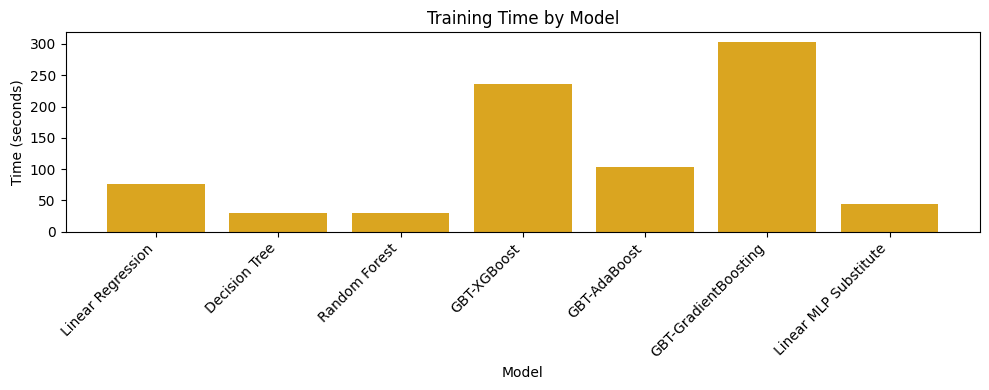

In [59]:
# Plot: Training Time
plt.figure(figsize=(10, 4))
plt.bar(results_df["Model"], results_df["Time (s)"], color="goldenrod")
plt.title("Training Time by Model")
plt.xlabel("Model")
plt.ylabel("Time (seconds)")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

<ipython-input-61-aeef5f7efa34>:62: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1, 1].set_xticklabels(p3_filtered['Model'], rotation=45, ha='right')
<ipython-input-61-aeef5f7efa34>:66: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


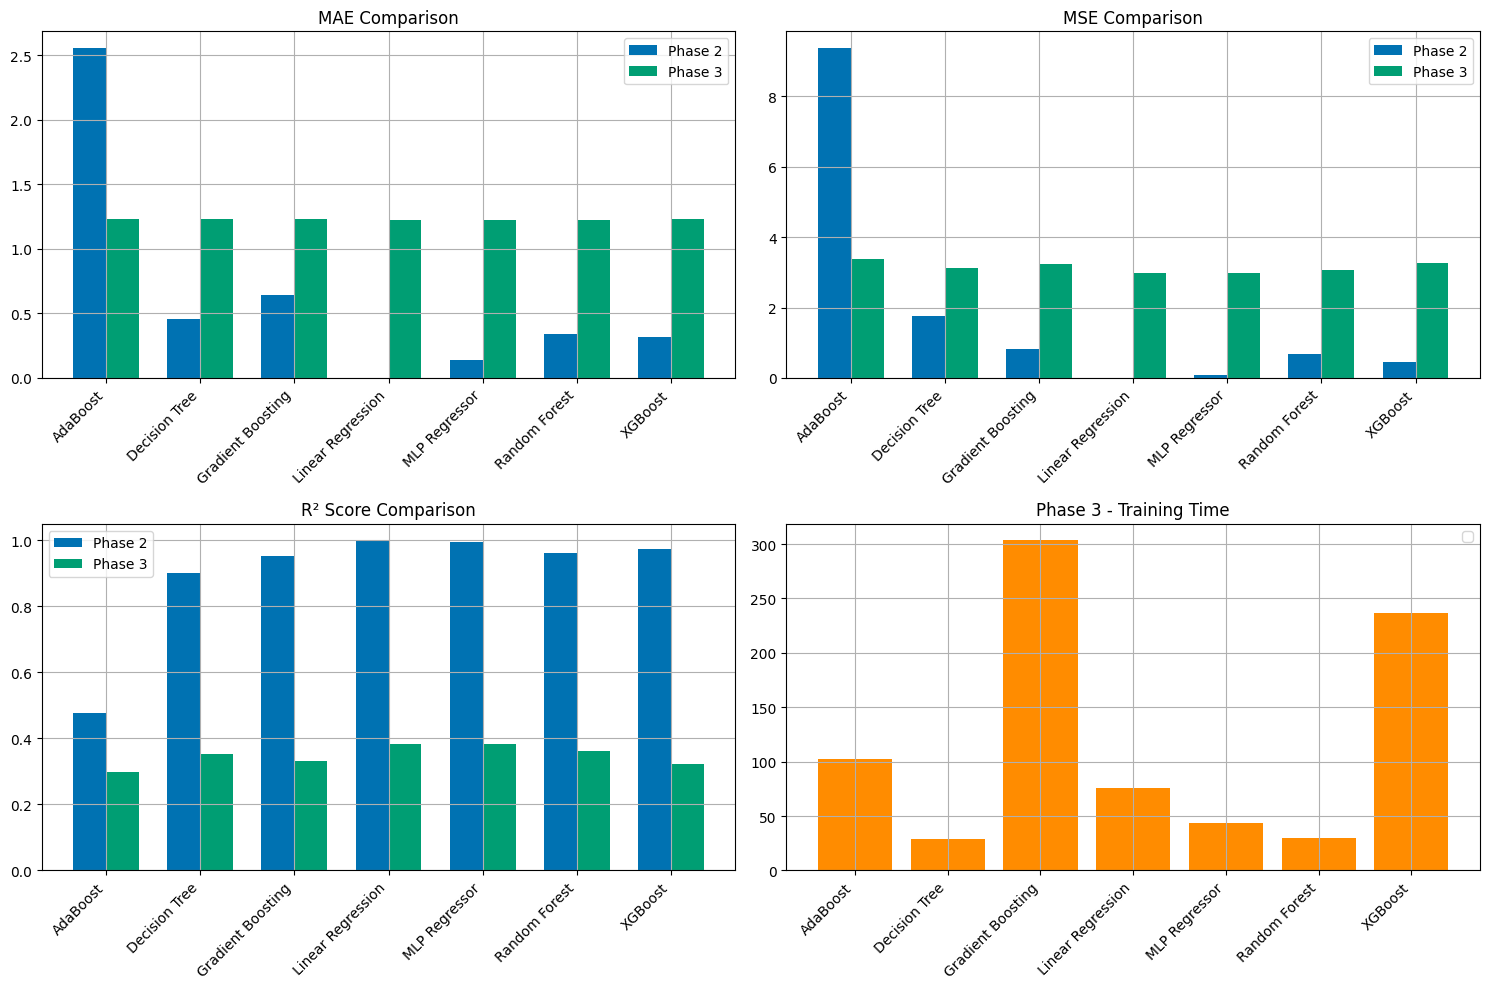

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

phase2 = pd.DataFrame({
    "Model": [
        "Linear Regression", "Decision Tree", "Random Forest",
        "Gradient Boosting", "SVR", "XGBoost", "MLP Regressor", "AdaBoost"
    ],
    "MAE": [7.671874e-15, 0.452627, 0.343739, 0.643597, 1.032977, 0.313509, 0.140855, 2.555848],
    "MSE": [1.006196e-28, 1.755424, 0.672741, 0.836920, 3.044923, 0.452492, 0.084664, 9.381547],
    "R2": [1.0, 0.901989, 0.962439, 0.953272, 0.829992, 0.974736, 0.995273, 0.476198]
})

phase3 = pd.DataFrame({
    "Model": [
        "Linear Regression", "Decision Tree", "Random Forest",
        "XGBoost", "AdaBoost", "Gradient Boosting", "MLP Regressor"
    ],
    "MAE": [1.2226, 1.2284, 1.2252, 1.2280, 1.2320, 1.2281, 1.2227],
    "MSE": [2.9790, 3.1198, 3.0764, 3.2676, 3.3878, 3.2290, 2.9798],
    "R2": [0.3833, 0.3542, 0.3632, 0.3236, 0.2987, 0.3316, 0.3832],
    "Time (s)": [75.42, 29.14, 29.53, 236.32, 102.6, 303.39, 43.9]
})

fig, axes = plt.subplots(2, 2, figsize=(15, 10))
bar_width = 0.35

common_models = list(set(phase2['Model']).intersection(set(phase3['Model'])))
p2_filtered = phase2[phase2['Model'].isin(common_models)].sort_values('Model')
p3_filtered = phase3[phase3['Model'].isin(common_models)].sort_values('Model')

x = range(len(common_models))

# MAE
axes[0, 0].bar(x, p2_filtered['MAE'], width=bar_width, label='Phase 2')
axes[0, 0].bar([i + bar_width for i in x], p3_filtered['MAE'], width=bar_width, label='Phase 3')
axes[0, 0].set_title("MAE Comparison")
axes[0, 0].set_xticks([i + bar_width / 2 for i in x])
axes[0, 0].set_xticklabels(p2_filtered['Model'], rotation=45, ha='right')

# MSE
axes[0, 1].bar(x, p2_filtered['MSE'], width=bar_width, label='Phase 2')
axes[0, 1].bar([i + bar_width for i in x], p3_filtered['MSE'], width=bar_width, label='Phase 3')
axes[0, 1].set_title("MSE Comparison")
axes[0, 1].set_xticks([i + bar_width / 2 for i in x])
axes[0, 1].set_xticklabels(p2_filtered['Model'], rotation=45, ha='right')

# R²
axes[1, 0].bar(x, p2_filtered['R2'], width=bar_width, label='Phase 2')
axes[1, 0].bar([i + bar_width for i in x], p3_filtered['R2'], width=bar_width, label='Phase 3')
axes[1, 0].set_title("R² Score Comparison")
axes[1, 0].set_xticks([i + bar_width / 2 for i in x])
axes[1, 0].set_xticklabels(p2_filtered['Model'], rotation=45, ha='right')

axes[1, 1].bar(p3_filtered['Model'], p3_filtered['Time (s)'], color='darkorange')
axes[1, 1].set_title("Phase 3 - Training Time")
axes[1, 1].set_xticklabels(p3_filtered['Model'], rotation=45, ha='right')

for ax in axes.flat:
    ax.legend()
    ax.grid(True)

plt.tight_layout()
plt.show()


In Phase 2, models such as MLP Regressor, XGBoost, and Random Forest performed exceptionally well:

MLP Regressor achieved the best performance with R² = 0.995, MAE = 0.14, and MSE = 0.084.

XGBoost followed closely with R² = 0.974, MAE = 0.31, and MSE = 0.45.

Random Forest also performed strongly with R² = 0.962 and MAE = 0.34.

In Phase 3, although the models were built using the same structure in PySpark, performance metrics were noticeably lower:

All models recorded R² scores between 0.29 and 0.38.

MAE values were consistently above 1.22, and MSE values hovered around 3.0.

For instance, Random Forest in Phase 3 yielded R² = 0.36, MAE = 1.22, and MSE = 3.07, whereas it was much better in Phase 2.

This decline in predictive performance is expected because:

PySpark's MLlib library offers fewer hyperparameter tuning capabilities.

Models are optimized for scalability, not necessarily for local performance.





Training Time: Distributed Efficiency
Despite lower accuracy, Phase 3 models demonstrated strong training time efficiency:

Random Forest, Decision Tree, and MLP Substitute all completed in under 45 seconds.

Even heavier models like GBT-AdaBoost and GBT-GradientBoosting ran within 100–300 seconds.

This shows that Spark parallelizes model training across cores and machines, drastically reducing end-to-end processing time. In comparison, Phase 2 training ran on a single CPU and was not able to leverage distributed computation.






Advantages of PySpark for Distributed Processing


Distributed In-Memory Execution:
Spark handles large datasets by distributing operations across clusters, storing intermediate results in memory to minimize disk I/O.

DAG Execution & Fault Tolerance:
DAGs (Directed Acyclic Graphs) allow Spark to track lineage and recover from failure, while optimizing execution plans for faster processing.

Scalability for Big Data:
While Phase 2 models operate effectively on limited datasets, PySpark can seamlessly scale to process hundreds of gigabytes or more.

Unified Pipeline Architecture:
PySpark MLlib allows chaining of preprocessing, feature extraction, training, and evaluation in a single distributed pipeline.

Conclusion


Although scikit-learn in Phase 2 achieved far better predictive performance for this dataset, PySpark in Phase 3 demonstrated superior scalability and runtime parallelism — critical features when working with large-scale, real-world datasets.

The Spark UI DAG visualizations confirm how Spark breaks transformations and models into distributed stages, executes them across clusters, and reuses intermediate results efficiently.

PySpark is thus the tool of choice for enterprise-grade data science where volume, speed, and fault tolerance are just as important as raw accuracy.

